In [1]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
from PIL import Image
from six import BytesIO
import numpy as np
import random
import glob

import tensorflow as tf

from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

## Utilities

In [2]:
def load_image_into_numpy_array(image_path):
    """ Load an image from file into a numpy array
    """
    img_data = tf.io.gfile.GFile(image_path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    im_width, im_height = image.size
    image_np = np.array(image.getdata()).reshape(im_height, im_width, 3).astype(np.uint8)

    return image_np

In [3]:
def plot_detection(image_np, boxes, classes, scores, category_index, min_score_thresh = 0.8, figsize=(12, 16), image_name = None):
    """ 
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates = True,
        min_score_thresh = min_score_thresh
    )
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

## Prepare data for training

In [4]:
data_dir = 'data/sample_data/hard_hat/rawdata/train/'

In [5]:
name_label_mappings = {
    'helmet': 1,
    'head': 2,
    'person': 3,
    # Add more classes as needed
}

### Read Roof TFRecord 

In [6]:
tfrecord_path = 'data/sample_data/hard_hat/annotations/train.tfrecord'

dataset = tf.data.TFRecordDataset(tfrecord_path)

In [7]:
# Define a function to parse each record
def parse_record(record):
    feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    
    example = tf.io.parse_single_example(record, feature_description)
    
    height, width = example['image/height'], example['image/width']
    filename = example['image/filename']

    # Extract bounding box coordinates
    xmin = tf.sparse.to_dense(example['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(example['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(example['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(example['image/object/bbox/ymax'])
    boxes = [ymin, xmin, ymax, xmax]

    # Convert class text and labels to dense tensors
    class_name = tf.sparse.to_dense(example['image/object/class/text'])
    class_label = tf.sparse.to_dense(example['image/object/class/label'])
    
    return filename, height, width, boxes, class_name, class_label

#### Convert to training dataset

In [8]:
# extract images and annotations
parsed_dataset = dataset.map(parse_record)

train_image_dir = 'data/sample_data/hard_hat/rawdata/train'

gt_boxes = []
train_images_np = []
classes_name = []
classes_intlabel = []
filenames = []
for filename, height, width, boxes, class_name, class_label in parsed_dataset:
    filenames.append(filename.numpy().decode())
    gt_boxes.append(boxes.numpy().T)

    # load image
    image_path = os.path.join(train_image_dir, filename.numpy().decode())
    train_images_np.append(load_image_into_numpy_array(image_path)) 


    classes_name.append([name.decode() for name in class_name.numpy()])
    classes_intlabel.append(class_label.numpy())
    

2024-04-16 11:46:42.697788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-16 11:46:42.705707: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
# By convention, our non-background classes start counting at 1.  

category_index = {}
for name, label in name_label_mappings.items():
    category_index[label] = {'id': label, 'name': name}

num_classes = len(name_label_mappings)

# shifts all classes by a certain number of indices; so this so that the model receives one-hot labels where non-background classes start
# counting at the zeroth index. This is ordinarily just handled automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1 

In [10]:
# convert everythin to tensors, convert class labels to one-hot
train_image_tensors = []
gt_box_tensors = []
gt_classes_one_hot_tensors = []
for train_image_np, gt_box, one_index_classes in zip(train_images_np, gt_boxes, classes_intlabel):
    train_image_tensors.append(tf.convert_to_tensor(train_image_np, dtype=tf.float32))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box, dtype=tf.float32))

    zero_indexed_groundtruth_classes = tf.convert_to_tensor(one_index_classes - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

### Visualize

visulize file 000093_jpg.rf.Vrxcccdr7VhUk4fJVEcC.jpg


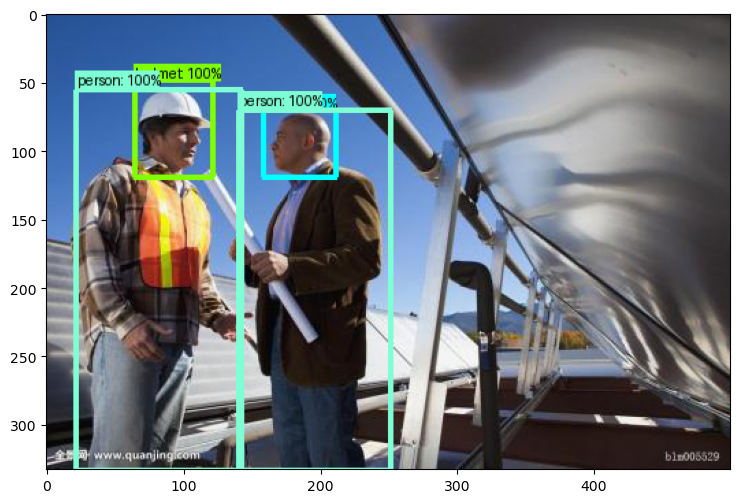

In [11]:
# select one file (e.g. 00093) to visualize
idx = [idx for idx, filename in enumerate(filenames) if filename.startswith('000093')]
idx = idx[0]

print(f"visulize file {filenames[idx]}")
dummy_scores = np.ones(shape=boxes.shape[0], dtype=np.float32)

plt.figure(figsize=(30,15))
plt.subplot(2, 3, 1)

plot_detection(
        train_images_np[idx],
        gt_boxes[idx],
        classes_intlabel[idx],
        dummy_scores, category_index)

## Create model and restore weights for all but last layer

In [14]:
tf.keras.backend.clear_session()

pipeline_config = 'object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/pretrained_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

In [16]:
# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(_feature_extractor=detection_model._feature_extractor,
                                           _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [17]:
# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


## Eager mode custom training loop

In [18]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned
batch_size = 20
learning_rate = 0.01
num_batches = 100

/opt/anaconda3/envs/tfod1/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [19]:
# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = ['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead', 
                    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [20]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""
    
    def train_step_fn(image_tensors, gt_boxes_list, gt_classes_list):
        """ A single training iteration

            Args:
                image_tensors:  a list of [height_in, width_in, channels] float tensor, len = batch_size 
        """
    
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(groundtruth_boxes_list = gt_boxes_list, groundtruth_classes_list =gt_classes_list)
    
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat([model.preprocess(tf.expand_dims(image_tensor, axis = 0))[0] for image_tensor in image_tensors],axis = 0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
    
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
            
        return total_loss

    return train_step_fn

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):

    # Grab a random subset of examples
    all_indices = list(range(len(train_images_np)))
    random.shuffle(all_indices)
    batch_indices = all_indices[0:batch_size]

    gt_boxes_list = [gt_box_tensors[idx] for idx in batch_indices]
    gt_classes_list = [gt_classes_one_hot_tensors[idx] for idx in batch_indices]
    image_tensors = [train_image_tensors[idx] for idx in batch_indices]

    # training
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

Start fine-tuning!
batch 0 of 100, loss=1.6547676
batch 10 of 100, loss=0.98041123


In [ ]:
## save 
saved_model_dir = 'finetuned_models/ssdResnetFPN'

# Step 1: Save the Model Architecture
saved_modelArch_dir = os.path.join(saved_model_dir, 'modelArch')
tf.saved_model.save(detection_model, saved_modelArch_dir)
print(f"Model architecture saved to: {saved_modelArch_dir}")

# Step 2:  Save the Trained Weights
checkpoint_dir = os.path.join(saved_model_dir, 'checkpoints')
checkpoint = tf.train.Checkpoint(model=detection_model, optimizer = optimizer)
checkpoint.save(os.path.join(checkpoint_dir, 'checkpoint'))
print(f"Trained weights saved to: {checkpoint_dir}")

## Load test images and run inference with new model

In [ ]:
def detect(model, input_tensor):
    """
        Args:
            input_tensor: [height, width, 3]
    """
    preprocessed_images, shapes = model.preprocess(tf.expand_dims(input_tensor, axis=0))
    prediction_dict = model.predict(preprocessed_images, shapes)
    postprocessed_dict = model.postprocess(prediction_dict, shapes)

    return postprocessed_dict

In [ ]:
test_image_dir = 'data/sample_data/hard_hat/rawdata/test'
test_filenames = glob.glob(test_image_dir + '/*.jpg')

for image_path in test_filenames:
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)

    detections = detect(model = reloaded_model, input_tensor=input_tensor)

    plot_detection(image_np,
                   detections['detection_boxes'][0].numpy(), 
                   detections['detection_classes'][0].numpy().astype(np.int32) + label_id_offset,
                   detections['detection_scores'][0].numpy(),
                   category_index, 
                   min_score_thresh = 0.5,
                   figsize=(15, 20), 
                   image_name=os.path.join(test_image_dir, 'detected_'+ os.path.basename(image_path)[:6] + ".jpg"))